# 🚗🚙🛻🚖Geração de clientes pelo dataset AGDA
Este notebook gera os clientes  para os testes de aprendizado federado a partir dos datests da AGDA.

In [ ]:
from huggingface_hub import login, list_repo_files, hf_hub_download
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os

In [ ]:
global dir_hf
login(token='fale-comigo:josewilson@matematica.ufrj.br')
dir_hf = 'jwsouza13/routes_ML_inmetro'

In [14]:
def load_data_folder(folder):
    """
    Baixa todos os arquivos de uma pasta específica em um dataset do Hugging Face.
    folder: ELETRONUCLEAR, SERRA ou RJ-DF
    """
    # todos os arquivos no dataset
    all_files = list_repo_files(repo_id=dir_hf, repo_type='dataset', use_auth_token=True)
    folder_files = [f for f in all_files if f.startswith('DATASET-'+folder + "/") and f.endswith('.csv')]
    downloaded_files = []

    for file in folder_files:
        local_path = hf_hub_download(
            repo_id=dir_hf,
            filename=file,
            repo_type='dataset',
            use_auth_token=True)
        downloaded_files.append(local_path)

    return downloaded_files

In [15]:
data_eletro = load_data_folder('ELETRONUCLEAR')
data_rjdf = load_data_folder('RJ-DF')
data_serra = load_data_folder('SERRA')

## 🚗🛻ELETRONUCLEAR☢️

In [16]:
### Dados Eletronuclear
dfs = []
for file in data_eletro:

  df = pd.read_csv(file, sep=';')
  id = file.split('\\')[-1]
  _,_,vehicle,_,_ = id.split('-')
  df = df.assign(id_route = id.replace('.csv',''),
                 vehicle = vehicle,
                 loc_coleta = 'eletronuclear')

  if 'pos_lat' not in df.columns: # dfs ruins
    dfs.append(df)

---

## 🚘🚙RJ-DF⛱️

In [17]:
# colunas originais e como devem ser
cols_orig = ['Time (sec)', ' Latitude (deg)', ' Longitude (deg)',
              ' Vehicle speed (km/h)', ' Accel X (m/s²)', ' Accel Y (m/s²)',
              ' Accel Z (m/s²)', ' Engine RPM (RPM)', ' Mass air flow rate (g/s)',
              ' Absolute throttle position (%)', ' Fuel level input (%)',
              ' GPS Speed (km/h)', ' Fuel rate (l/hr)',
              ' Alcohol fuel percentage (%)', ' Engine fuel rate (l/hr)',
              ' Vehicle Fuel Rate (g/s)', ' Fuel Remaining (l)',
              ' Fuel Level Input A (%)', ' Fuel Level Input B (%)',
              ' Instant fuel economy (l/100 km)', ' Calculated load value (%)',
              ' Fuel rail pressure (kPa)',
              ' Fuel rail pressure relative to manifold vacuum (kPa)',
              ' Accelerator pedal position D (%)',
              ' Accelerator pedal position E (%)']

cols_rjdf = ['time','lat','lon','vehicle_speed','accel_x','accel_y','accel_z','engine_rpm',
              'mass_air_flow','absolute_throttle_pos','fuel_level','gps_speed',
              'fuel_rate','alcohol_fuel_percentage','engine_fuel_rate','vehicle_fuel_rate',
              'fuel_remaining','fuel_level_a','fuel_level_b','instant_fuel_economy',
              'calculated_load_value','fuel_rail_pressure_vacuum','fuel_rail_pressure',
              'accelerator_pedal_pos_d','accelerator_pedal_pos_e']

zip_cols = [(orig,col) for orig,col in zip(cols_orig,cols_rjdf)]

In [18]:
for dado in data_rjdf:

  df = pd.read_csv(dado, skiprows=2)

  if df.columns.to_list()!=cols_orig:
    df = pd.read_csv(dado, skiprows=1)

  df = df.rename(columns=dict(zip_cols))
  df = df.assign(id_route = dado.split('\\')[-1].replace('.csv',''),
                 vehicle = 'nivus',
                 loc_coleta = 'rjdf')
  dfs.append(df)

## 🚙SERRA🪚

In [19]:
for dado in data_serra:
  df_serra = pd.read_csv(dado, skiprows=1)
  df_serra = df_serra.rename(columns=dict(zip_cols))
  df_serra = df_serra.assign(id_route = data_serra[0].split('\\')[-1].replace('.csv',''),
                              vehicle = 'jetta',
                              loc_coleta = 'serra')

  dfs.append(df_serra)

---

In [20]:
def latlon_to_cartesian(latitudes, longitudes):
  '''
  Função que converte as coordenadas de latitude e longitude para coordenadas
  cartesianas.
  '''

  latitudes_rad = [math.radians(lat) for lat in latitudes]
  longitudes_rad = [math.radians(lon) for lon in longitudes]

  # Origem
  lat0 = latitudes_rad[0]
  lon0 = longitudes_rad[0]
  R = 6371000 # raio da Terra

  cartesian_coords = []
  for lat, lon in zip(latitudes_rad, longitudes_rad):
    if lat != lat0 or lon != lon0:
      x = R * (lon - lon0) * math.cos((lat + lat0) / 2)
      y = R * (lat - lat0)
      cartesian_coords.append((x, y))

    else:
      cartesian_coords.append((0, 0))

  return cartesian_coords

---

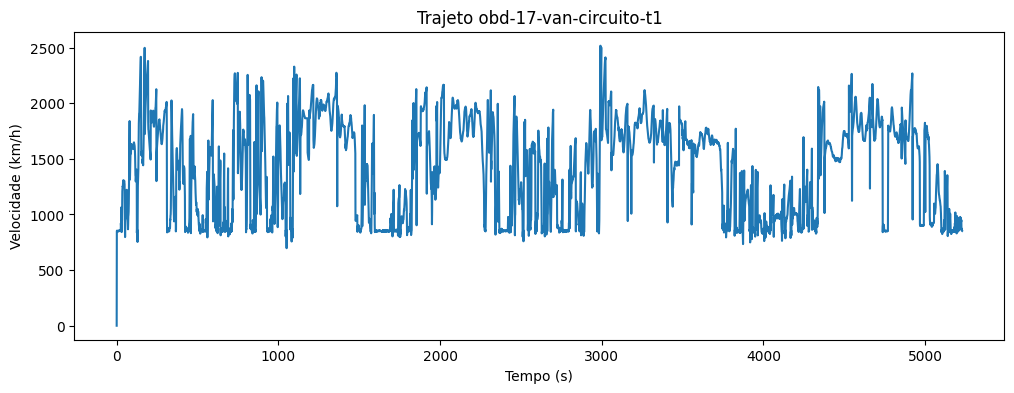

In [21]:
dfr = dfs[7].copy()
id_route = dfr.id_route.unique()[0]
fig, ax = plt.subplots(figsize=(12,4))
y = dfr.vehicle_speed
plt.plot(y, '-')
plt.title(f'Trajeto {id_route}')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (km/h)')
plt.show()

**Obs.:** Os trajetos nas posições 6 e 7 de `dfs` tem dados ruins de velocidade, eu suponho que foram multiplicados por 100. Mas vou desconsidera-los

In [ ]:
new_dfs = []
dfruim = ['obd-17-van-cicuito-t2', 'obd-17-van-circuito-t1'] # excluindo dfs ruins, obd-17-van-cicuito-t2 e obd-17-van-circuito-t1
dfs = [df for df in dfs if df.id_route.unique()[0] not in dfruim]
for df in dfs:

  if len(set(['rjdf', 'serra']) & set(df.loc_coleta.unique())) > 0:
    df['time_sec'] = df.time # pois esses dados já vem com o time em segundos

  else: # a coluna timestamp precisa estar nesses dfs (nesse caso são os dados da eletro)
    df.timestamp = pd.to_datetime(df.timestamp, format="mixed") # ajuste do tempo
    df['time_sec'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()
    df = df.set_index('timestamp').sort_index()
    df[['vehicle_speed','lat','lon']] = (df[['vehicle_speed','lat','lon']].interpolate(method='time')) # isso porque houve algumas quebras de dados, isso preenche os dados faltantes

  # delta de tempo
  df['dt'] = df['time_sec'].diff().fillna(0)

  # identifica velocidade onde o veículo estava parado no passo anterior
  df['prev_speed'] = df['vehicle_speed'].shift(1).fillna(0)

  # zera o dt sempre que o passo anterior teve speed == 0 e fuel_rate == 0
  df.loc[(df['prev_speed'] == 0) & (df['fuel_rate']==0), 'dt'] = 0

  # elimina a coluna auxiliar
  df.drop(columns='prev_speed', inplace=True)

  rows_prev, cols_pre = df.shape

  # agora filtra as velocidades > 0, descartando as baixissimas velocidades e acelerações
  df = df[~((df['vehicle_speed'] < 1) & (df['accel_x'].abs() < 0.005) & (df['accel_y'].abs() < 0.005))]
  df = df.drop_duplicates(subset = ['lat','lon','vehicle_speed','fuel_rate'], keep='last') # removendo duplicatas de coordenadas, velocidade e combustivel
  df.reset_index(drop=True, inplace=True)

  coor = latlon_to_cartesian(df['lat'], df['lon']) # convertendo coordenadas
  x,y = zip(*coor)
  df = df.assign(x=x, y=y)

  for col in df.columns: # Deletando colunas que só possui 0 ou só céluas vazias
    if np.all(df[col] == 0) or df[col].notnull().sum() == 0:
      df.drop(columns=col, inplace=True)

  new_dfs += [df.copy()]

  rows_now, cols_now = df.shape
  print(f'(Trajeto {len(new_dfs)}) Linhas removidas: {rows_prev - rows_now}, tinha {rows_prev}, agora tem {rows_now}. Numero de colunas antes: {cols_pre}, depois: {cols_now}')

(Trajeto 1) Linhas removidas: 92415, tinha 99493, agora tem 7078. Numero de colunas antes: 29, depois: 21
(Trajeto 2) Linhas removidas: 255649, tinha 258726, agora tem 3077. Numero de colunas antes: 29, depois: 22
(Trajeto 3) Linhas removidas: 258278, tinha 264023, agora tem 5745. Numero de colunas antes: 29, depois: 22
(Trajeto 4) Linhas removidas: 39781, tinha 40600, agora tem 819. Numero de colunas antes: 25, depois: 20
(Trajeto 5) Linhas removidas: 8753, tinha 9238, agora tem 485. Numero de colunas antes: 29, depois: 23
(Trajeto 6) Linhas removidas: 5631, tinha 6026, agora tem 395. Numero de colunas antes: 29, depois: 23
(Trajeto 7) Linhas removidas: 23945, tinha 25361, agora tem 1416. Numero de colunas antes: 29, depois: 24
(Trajeto 8) Linhas removidas: 23034, tinha 29544, agora tem 6510. Numero de colunas antes: 29, depois: 24
(Trajeto 9) Linhas removidas: 9426, tinha 12133, agora tem 2707. Numero de colunas antes: 28, depois: 28
(Trajeto 10) Linhas removidas: 4345, tinha 10021, 

---

In [ ]:
dfs_clent_0 = [df for df in new_dfs if "spin" in df.vehicle.unique()]
dfs_clent_1 = [df for df in new_dfs if "van" in df.vehicle.unique()]
dfs_clent_2 = [df for df in new_dfs if 'rjdf' in df.loc_coleta.unique()]

In [ ]:
for set_df, id_clt in zip([dfs_clent_0, dfs_clent_1, dfs_clent_2], ['client0', 'client1', 'client2']):

  for df in set_df:
    if 'van' in df.vehicle.unique():
      df['P_kW'] = df['fuel_rate'] * 42.5e6 / 3600 / 1e3 # J/h, J/s = W & W --> kW (diesel)

    else:
      df['P_kW'] = df['fuel_rate'] * 34.86e6 / 3600 / 1e3 # J/h, J/s = W & W --> kW (gasolina)

    df['client'] = id_clt

💾 salvar datasets individuais dos percursos por cliente

In [ ]:
os.makedirs('AGDA_Clients/client_0', exist_ok=True)
os.makedirs('AGDA_Clients/client_1', exist_ok=True)
os.makedirs('AGDA_Clients/client_2', exist_ok=True)

In [ ]:
id=0
for df in dfs_clent_0:
  df.to_csv(f'AGDA_Clients/client_0/trip_{id}.csv', index=False)
  id += 1

id = 0
for df in dfs_clent_1:
  df.to_csv(f'AGDA_Clients/client_1/trip_{id}.csv', index=False)
  id += 1

id = 0
for df in dfs_clent_2:
  df.to_csv(f'AGDA_Clients/client_2/trip_{id}.csv', index=False)
  id += 1

---
---